In [352]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np 

In [518]:
# sudaro vieną partiją atsitiktinai prisirdamas ėjimus
def one_random_game():
    board = np.zeros((9,3,3))
    
    coin_toss = np.random.choice([-1,1])
    
    current_player = coin_toss

    for turn in range(0,9):
        if turn > 0:
            board[turn,:,:] = board[turn-1,:,:]
      
        current_player = current_player * -1
        
        while True:
            choice = np.random.randint(0, 9)
            if board[turn,choice // 3, choice % 3] == 0:
                board[turn,choice // 3, choice % 3] = current_player
                break
    return board

In [534]:
# tikrina ar yra laimėtojas
def check_winner(boards):
    for i in boards:
        results = np.concatenate((
                        np.array([np.sum(np.diagonal(i))]),
                        np.array([np.sum(np.diagonal(np.fliplr(i)))]),
                        np.sum(i,1),
                        np.sum(i,0)))

        if np.any(np.isin(results,3)):
            return 1
        elif np.any(np.isin(results,-3)):
            return -1
        
    return 0

In [535]:
# simuliuoja n atsitiktinių partijų
def simulate_games(n):
    boards = []
    winners = []
    for i in range(0,n):
        board = one_random_game()
        boards.append(board)
        winners.append(check_winner(board))
    return boards, winners

In [689]:
# paruošiami mokymo duomenys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

onehotencoder_X = OneHotEncoder()
    
onehotencoder_y = OneHotEncoder()
onehotencoder_y.fit(np.array([-1,0,1]).reshape(-1,1))

def create_data(n):
    boards, winners = simulate_games(n)
    X = []
    for board in boards:
        X.append(board[np.random.randint(0, 9)].flatten())
    
    # one-hot formatas rezultatui
    y = onehotencoder_y.transform(np.array(winners).reshape(-1,1)).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,test_size=0.2)
    
    # one-hot formatas lentos būsenai
    X_train = onehotencoder_X.fit_transform(X_train).toarray()
    X_test = onehotencoder_X.transform(X_test).toarray()
    X_train = np.delete(X_train, [0,3,6,9,12,15,18,21,24], axis=1)
    X_test = np.delete(X_test, [0,3,6,9,12,15,18,21,24], axis=1)

    return X_train, X_test, y_train, y_test

In [704]:
X_train, X_test, y_train, y_test = create_data(10000)

In [705]:
inputs = tf.keras.Input(shape=(18,))

x = layers.Dense(units=128, kernel_initializer='uniform', activation='relu')(inputs)
x = layers.Dense(units=64, kernel_initializer='uniform', activation='relu')(x)
output = layers.Dense(units=3, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [706]:
history = model.fit(X_train,y_train, batch_size=10, epochs=15)

Epoch 1/15
800/800 [==============================] - 4s 3ms/step - loss: 0.9665 - accuracy: 0.4990
Epoch 2/15
800/800 [==============================] - 3s 3ms/step - loss: 0.8925 - accuracy: 0.5386
Epoch 3/15
800/800 [==============================] - 2s 3ms/step - loss: 0.8194 - accuracy: 0.5870
Epoch 4/15
800/800 [==============================] - 1s 2ms/step - loss: 0.7692 - accuracy: 0.6339
Epoch 5/15
800/800 [==============================] - 2s 3ms/step - loss: 0.7302 - accuracy: 0.6526
Epoch 6/15
800/800 [==============================] - 2s 3ms/step - loss: 0.7036 - accuracy: 0.6619
Epoch 7/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6899 - accuracy: 0.6705
Epoch 8/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6753 - accuracy: 0.6770
Epoch 9/15
800/800 [==============================] - 2s 2ms/step - loss: 0.6675 - accuracy: 0.6805
Epoch 10/15
800/800 [==============================] - 2s 3ms/step - loss: 0.6612 - accuracy: 0.6800

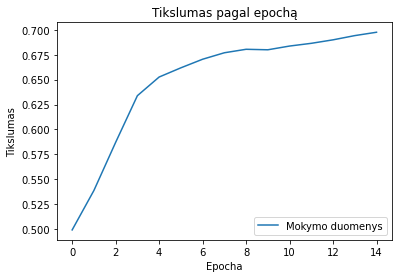

In [718]:
plt.plot(history.history['accuracy'], label='Mokymo duomenys')
plt.xlabel('Epocha')
plt.ylabel('Tikslumas')
plt.legend(loc='lower right')
plt.title("Tikslumas pagal epochą")
plt.show()

In [682]:
def next_moves(current_board):
    
    n_possible_moves = np.where(current_board==0)[0].shape[0]
    possible_moves = np.repeat(np.reshape(current_board,(1,3,3)),n_possible_moves,axis=0)
    model_format = np.zeros((n_possible_moves,9))
    
    for i in range(len(possible_moves)):
        possible_moves[i,np.where(current_board==0)[0][i],np.where(current_board==0)[1][i]] = -1
        model_format[i,:] = possible_moves[i,:,:].flatten()
        
    return possible_moves, model_format

In [683]:
# atspausdina tuo metu esančią lentą su 'X' ir 'O' 
def print_board(board):
    board_print = np.empty_like(board,str)
    board_print[board == 1] = 'X'
    board_print[board == -1] = 'O'
    print(board_print)

In [691]:
# skirta žaisti su apmokytu modeliu
def play(model, verbose = True):
    
    board = np.zeros((3,3))
    coin_toss = np.random.choice([-1,1]) 
    current_player = coin_toss

    for i in range(0,9):

        current_player = current_player * -1

        if verbose:
            print_board(board)

        winner = check_winner(board.reshape(1,3,3))

        if winner == 1:
            print("\nJūs laimėjote")
            return 1

        elif winner == -1:
            print("\nJūs pralaimėjote")
            return -1

        if current_player == 1:
            while True:
                row = int(input('Pasirinkite eilutę\n'))
                column = int(input('Pasirinkite stulpelį\n'))
                if board[row,column] != 0:
                    print("Negalima, pasirinkite iš naujo!\n")
                else:
                    board[row,column] = 1
                    break
        else:
            possible_moves, model_format = next_moves(board)

            model_format = onehotencoder_X.transform(model_format).toarray()
            model_format =  np.delete(model_format, [0,3,6,9,12,15,18,21,24], axis=1)

            board = possible_moves[np.argmax(model.predict(model_format)[:,0])]

        if i == 8:
            print("\nLygiosios")
            return 0

In [ ]:
play(model)

In [724]:
# skirta žaisti su apmokytu modeliu
def play_random(model):
    
    board = np.zeros((3,3))
    coin_toss = np.random.choice([-1,1]) 
    current_player = coin_toss

    for i in range(0,9):

        current_player = current_player * -1

        winner = check_winner(board.reshape(1,3,3))

        if winner == 1:
            return 1

        elif winner == -1:
            return -1

        if current_player == 1:
            while True:
                choice = np.random.randint(0, 9)
                if board[choice // 3, choice % 3] == 0:
                    board[choice // 3, choice % 3] = 1
                    break
        else:
            possible_moves, model_format = next_moves(board)

            model_format = onehotencoder_X.transform(model_format).toarray()
            model_format =  np.delete(model_format, [0,3,6,9,12,15,18,21,24], axis=1)

            board = possible_moves[np.argmax(model.predict(model_format)[:,0])]

        if i == 8:
            
            return 0

In [729]:
def play_n(n):
    winners = []
    for i in range(n):
        winners.append(play_random(model))
    print("Modelis laimėjo " + str(np.sum(np.array(winners)==-1)/n*100) + "%")
    print("Lygiosios " + str(np.sum(np.array(winners)==0)/n*100) + "%")

In [732]:
play_n(100)

Modelis laimėjo 93.0%
Lygiosios 1.0%
